In [19]:
# Deep Learning Fundamentals: MNIST Case Study
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from time import time
from collections import defaultdict
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Data Collection

In [2]:
import requests

# URLs of the files
data_train_features_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_features.csv'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_labels.csv'
data_test_features_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_test_features.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_train_features_url, 'module7_exercise_train_features.csv')
download_file(data_train_labels_url, 'module7_exercise_train_labels.csv')
download_file(data_test_features_url, 'module7_exercise_test_features.csv')

Downloaded module7_exercise_train_features.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_features.csv
Downloaded module7_exercise_train_labels.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_labels.csv
Downloaded module7_exercise_test_features.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_test_features.csv


In [3]:
X = pd.read_csv('module7_exercise_train_features.csv').values
y = pd.read_csv('module7_exercise_train_labels.csv').values.ravel()

### Data Analysis

In [4]:
X.shape

(60000, 784)

In [5]:
y.shape

(60000,)

In [6]:
def plot_mnist_digits(X, y, num_examples=5, figsize=(15, 3)):
    # Create figure
    fig, axes = plt.subplots(1, num_examples, figsize=figsize)
    
    # Ensure axes is always a numpy array
    if num_examples == 1:
        axes = np.array([axes])
    
    # Plot each example
    for i in range(num_examples):
        # Reshape the flattened image back to 28x28
        img = X[i].reshape(28, 28)
        
        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

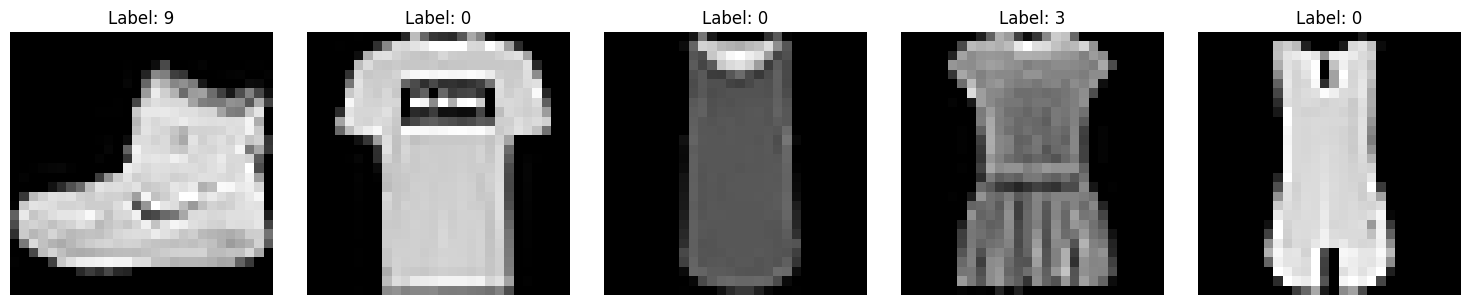

In [7]:
# Plot some examples
fig = plot_mnist_digits(X, y, num_examples=5)
plt.show()

### Data Preprocessing
Scale, split the data and create dataLoaders

In [8]:
def preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42):
    # Scale features 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into train+val and test 拆分成训练+验证集和测试集
    test_size = 1 - train_size - val_size
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_scaled, y, test_size=test_size, 
        random_state=random_state, stratify=y
    )
    #stratify=y：保证拆分后每个数据集中的类别分布与原始数据一致（适用于分类问题）
    
    # Split train+val into train and val 进一步拆分训练+验证集
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, 
        test_size=val_size/(train_size + val_size),
        random_state=random_state, stratify=y_trainval
    )
    
    # Convert to tensors and create dataloaders
    data_loader_train=DataLoader(
            TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
            batch_size=batch_size, shuffle=True
        )

    data_loader_val=DataLoader(
            TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
            batch_size=batch_size
        )
    
    data_loader_test=DataLoader(
            TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)),
            batch_size=batch_size
        )
    
    return data_loader_train, data_loader_val, data_loader_test

In [9]:
data_loader_train, data_loader_val, data_loader_test = preprocess_data(X, y)

### Model
Create a simple model with right input output and define criterion and criterion/loss

In [21]:
def create_model(device):
    dropout_rate = 0.2
    model = nn.Sequential(
                # First hidden layer
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),  #对隐藏层的输出进行批标准化，加速训练，防止过拟合
                nn.Dropout(dropout_rate),  #以 20% 的概率随机丢弃神经元
                
                # Second hidden layer
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(dropout_rate),
                
                # Third hidden layer
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(dropout_rate),
                
                # Output layer
                nn.Linear(128, 10)
            ).to(device)
    
    
    # Define loss function
    criterion = nn.CrossEntropyLoss().to(device)  #交叉熵损失函数，适用于多分类任务
    
    # Define optimizer (with reasonable defaults)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.01,
        betas=(0.9, 0.999),  #Adam 的动量参数
        eps=1e-08,  #避免分母为零的小值
        weight_decay=0.0001  #权重衰减，用于 L2 正则化，防止过拟合
    )

    # #学习率调度器：当验证损失在若干个周期（patience）内未降低时，调整学习率
    # scheduler = ReduceLROnPlateau(
    #     optimizer,
    #     mode='min',
    #     factor=0.1,
    #     patience=5,
    #     verbose=True,
    #     min_lr=1e-6
    # )
    return model, criterion, optimizer

### Train
Create a loop to train your model

In [11]:
def train_epoch(model, loader, criterion, optimizer, device, is_training=True):
    """Run one epoch of training or validation."""
    model.train() if is_training else model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    context = torch.enable_grad() if is_training else torch.no_grad()
    with context:
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            if is_training:
                optimizer.zero_grad()
                
            output = model(data)
            loss = criterion(output, target)
            
            if is_training:
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    
    history = defaultdict(list)
    for epoch in range(num_epochs):
        epoch_start = time()
        
        # Training phase
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, is_training=True
        )
        
        # Validation phase
        val_loss, val_acc = train_epoch(
            model, val_loader, criterion, optimizer, device, is_training=False
        )

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {time() - epoch_start:.2f}s")
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)
    return history

In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and training components
model, criterion, optimizer = create_model(device)

# Train the model
history = train_model(
    model=model,
    train_loader=data_loader_train,
    val_loader=data_loader_val,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=50
)


Epoch 1/50 - Time: 3.46s
Train Loss: 0.6340 - Train Acc: 77.41%
Val Loss: 0.4752 - Val Acc: 82.52%
Learning Rate: 0.010000
------------------------------------------------------------

Epoch 2/50 - Time: 3.53s
Train Loss: 0.5649 - Train Acc: 80.14%
Val Loss: 0.5137 - Val Acc: 81.20%
Learning Rate: 0.010000
------------------------------------------------------------

Epoch 3/50 - Time: 3.54s
Train Loss: 0.5549 - Train Acc: 80.63%
Val Loss: 0.5140 - Val Acc: 79.71%
Learning Rate: 0.010000
------------------------------------------------------------

Epoch 4/50 - Time: 3.58s
Train Loss: 0.5467 - Train Acc: 80.99%
Val Loss: 0.4890 - Val Acc: 81.47%
Learning Rate: 0.010000
------------------------------------------------------------

Epoch 5/50 - Time: 3.54s
Train Loss: 0.5327 - Train Acc: 81.42%
Val Loss: 0.5164 - Val Acc: 81.53%
Learning Rate: 0.010000
------------------------------------------------------------

Epoch 6/50 - Time: 3.56s
Train Loss: 0.5327 - Train Acc: 81.51%
Val Loss: 

In [15]:
def plot_training_history(history):
    """
    Plot training history
    
    Parameters:
    -----------
    history : dict
        Training history containing metrics
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Plot learning rate
    ax3.plot(history['lr'])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate over Time')
    ax3.set_yscale('log')
    ax3.grid(True)
    
    # Plot loss vs accuracy
    ax4.scatter(history['train_loss'], history['train_acc'], label='Train')
    ax4.scatter(history['val_loss'], history['val_acc'], label='Val')
    ax4.set_xlabel('Loss')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Loss vs Accuracy')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    return fig

In [16]:
print(history)

defaultdict(<class 'list'>, {'train_loss': [0.6340117644510103, 0.5649243207692374, 0.554939499075233, 0.5466706832333185, 0.5327283528499356, 0.5327080677051356, 0.5250221484618067, 0.5224797811135026, 0.5230436924524373, 0.5263421540598967, 0.5202249440294318, 0.5241501005614703, 0.5217908428129311, 0.5185982711494015, 0.5191840090464747, 0.5202161565434361, 0.5225839498314527, 0.5197886540997781, 0.5217752674337752, 0.5235255206144228, 0.5181695159470772, 0.5191910757490995, 0.5143933820524746, 0.5225081631611616, 0.5189405461859812, 0.51453261356588, 0.5174679961920874, 0.5167183477462746, 0.513916154025351, 0.5229454204292581, 0.5149667178254407, 0.519859044427465, 0.5172469296917512, 0.5191261317447589, 0.517602847127268, 0.5174004071181454, 0.514511142502009, 0.5142449964822383, 0.5141973069954808, 0.5183044991712032, 0.5172196105349545, 0.5193569480192544, 0.5159887299679293, 0.5186180060747827, 0.5195260070270014, 0.5161507320898867, 0.5171428265252916, 0.5161625060840862, 0.5

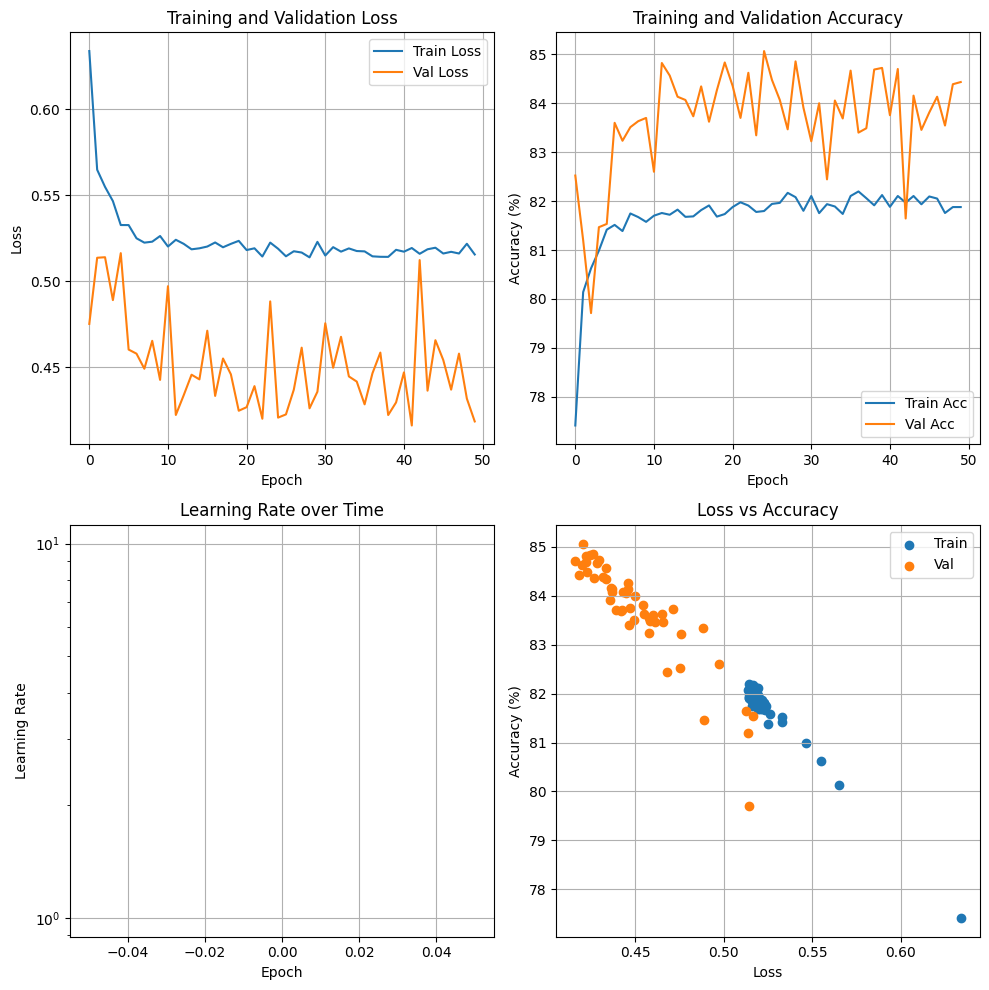

In [17]:
# Plot training history
plot_training_history(history)
plt.show()


In [18]:
### Improve your model and trainning

In [22]:
def create_model_2(device):
    dropout_rate = 0.2
    model = nn.Sequential(
                # First hidden layer
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),  #对隐藏层的输出进行批标准化，加速训练，防止过拟合
                nn.Dropout(dropout_rate),  #以 20% 的概率随机丢弃神经元
                
                # Second hidden layer
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(dropout_rate),
                
                # Third hidden layer
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(dropout_rate),
                
                # Output layer
                nn.Linear(128, 10)
            ).to(device)
    
    
    # Define loss function
    criterion = nn.CrossEntropyLoss().to(device)  #交叉熵损失函数，适用于多分类任务
    
    # Define optimizer (with reasonable defaults)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.01,
        betas=(0.9, 0.999),  #Adam 的动量参数
        eps=1e-08,  #避免分母为零的小值
        weight_decay=0.0001  #权重衰减，用于 L2 正则化，防止过拟合
    )

    #学习率调度器：当验证损失在若干个周期（patience）内未降低时，调整学习率
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )
    return model, criterion, optimizer, scheduler

In [18]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [23]:
def train_model_2(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=100, patience=7, checkpoint_path='best_model.pt'):
    """Train a model with early stopping and checkpointing."""
    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)
    history = defaultdict(list)
    best_acc = 0.0
    start_time = time()
    
    print("Training started...")
    for epoch in range(num_epochs):
        epoch_start = time()
        
        # Training phase
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, is_training=True
        )
        
        # Validation phase
        val_loss, val_acc = train_epoch(
            model, val_loader, criterion, optimizer, device, is_training=False
        )

        scheduler.step(val_loss)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {time() - epoch_start:.2f}s")
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
            }, 'best_acc_model.pt')
    
    total_time = time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best validation accuracy: {best_acc:.2f}%")
    
    return history

In [24]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and training components
model, criterion, optimizer, scheduler = create_model_2(device)

# Train the model
history_2 = train_model_2(
    model=model,
    train_loader=data_loader_train,
    val_loader=data_loader_val,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    num_epochs=50,
    patience=7
)

c:\Users\Neroued\.conda\envs\MPI\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training started...

Epoch 1/50 - Time: 3.36s
Train Loss: 0.6343 - Train Acc: 77.53%
Val Loss: 0.4881 - Val Acc: 82.44%
Learning Rate: 0.010000
------------------------------------------------------------
Validation loss decreased (inf --> 0.488136). Saving model ...

Epoch 2/50 - Time: 3.55s
Train Loss: 0.5626 - Train Acc: 80.08%
Val Loss: 0.4604 - Val Acc: 83.33%
Learning Rate: 0.010000
------------------------------------------------------------
Validation loss decreased (0.488136 --> 0.460421). Saving model ...

Epoch 3/50 - Time: 3.43s
Train Loss: 0.5574 - Train Acc: 80.49%
Val Loss: 0.4755 - Val Acc: 82.70%
Learning Rate: 0.010000
------------------------------------------------------------
EarlyStopping counter: 1 out of 7

Epoch 4/50 - Time: 3.40s
Train Loss: 0.5439 - Train Acc: 81.04%
Val Loss: 0.4769 - Val Acc: 82.64%
Learning Rate: 0.010000
------------------------------------------------------------
EarlyStopping counter: 2 out of 7

Epoch 5/50 - Time: 3.52s
Train Loss: 0.5

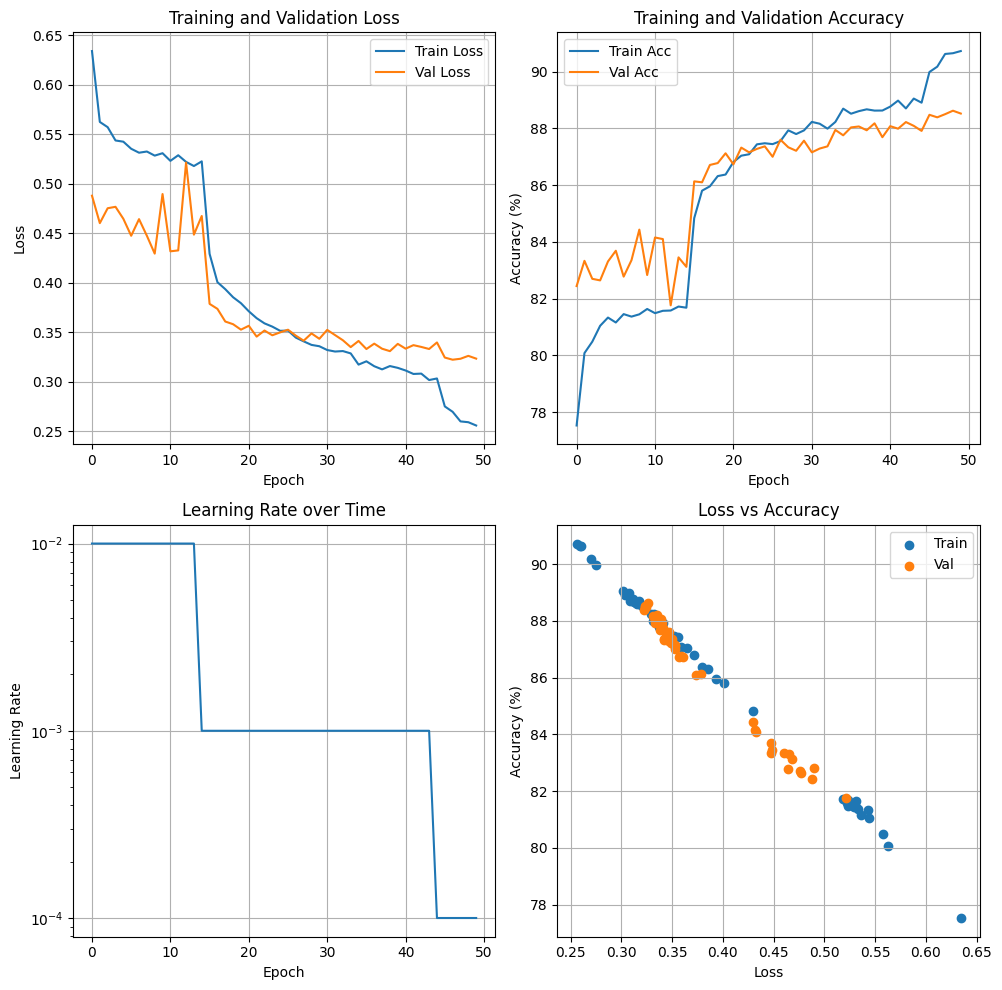

In [25]:
# Plot training history
plot_training_history(history_2)
plt.show()


### Generating Submission File

In [26]:
X_test = pd.read_csv('module7_exercise_test_features.csv')
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [30]:
# 加载模型的权重
checkpoint = torch.load('best_acc_model.pt', map_location=device)

# 加载模型状态
model.load_state_dict(checkpoint['model_state_dict'])

# 如果需要继续训练，还可以加载优化器状态
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 打印加载的模型信息
print(f"Model restored from epoch {checkpoint['epoch']}")
print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%")


Model restored from epoch 48
Validation accuracy: 88.62%


C:\Users\Neroued\AppData\Local\Temp\ipykernel_44836\3750987261.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_acc_model.pt', map_location=

In [31]:
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=10, bias=True)
)

In [32]:
# 确保测试张量和模型在同一设备上
X_test_tensor = X_test_tensor.to(device)

# 预测阶段
with torch.no_grad():
    predictions = model(X_test_tensor)  # logits 输出
#     probabilities = torch.softmax(predictions, dim=1)  # 转换为概率
#     predicted_classes = probabilities.argmax(dim=1)  # 获取预测类别

# print(f"Predicted classes: {predicted_classes}")


In [33]:
_, predicted_labels = torch.max(predictions, dim=1)

In [35]:
submission = pd.DataFrame({
    'index': list(range(len(predicted_labels))),  # 创建索引
    'label': predicted_labels.cpu().numpy()  # 将张量转换为 NumPy
})

# 保存为 CSV 文件
submission.to_csv('submission.csv', index=False, sep=',')
submission.head()


,index,label
0,0,9
1,1,2
2,2,1
3,3,1
4,4,6


In [43]:
if isinstance(X_test, pd.DataFrame):
    X_test_2 = X_test.values  # 转换为 NumPy 数组


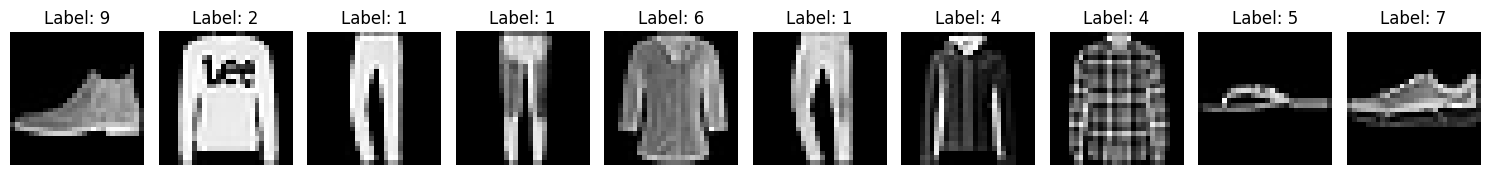

In [49]:
# Plot some examples
fig = plot_mnist_digits(X_test_2, predicted_labels.cpu().numpy(), num_examples=10)
plt.show()